In this notebook I add weather informations, such as temperature and precipitations, to the training set of the [COVID-19 forecasting competition](https://www.kaggle.com/c/covid19-global-forecasting-week-1/discussion), in order to determine whether there is any correlation with the growth of confirmed cases. Weather data is imported from the [NOAA GSOD dataset](https://www.kaggle.com/noaa/gsod), continuously updated to include recent measurments.

# Week 1:

In [1]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

from google.cloud import bigquery

data_path = Path('/kaggle/input/covid19-global-forecasting-week-1/')
train = pd.read_csv(data_path / 'train.csv')
test = pd.read_csv(data_path / 'test.csv')
display(train.head())
display(test.head())

/kaggle/input
/kaggle/input/covid19-global-forecasting-week-2
/kaggle/input/covid19-global-forecasting-week-1


,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16


There are 163 different nations in the training dataset.
145 of these nations have confirmed cases of COVID-19.
In 90 of these nations, people have died of COVID-19.


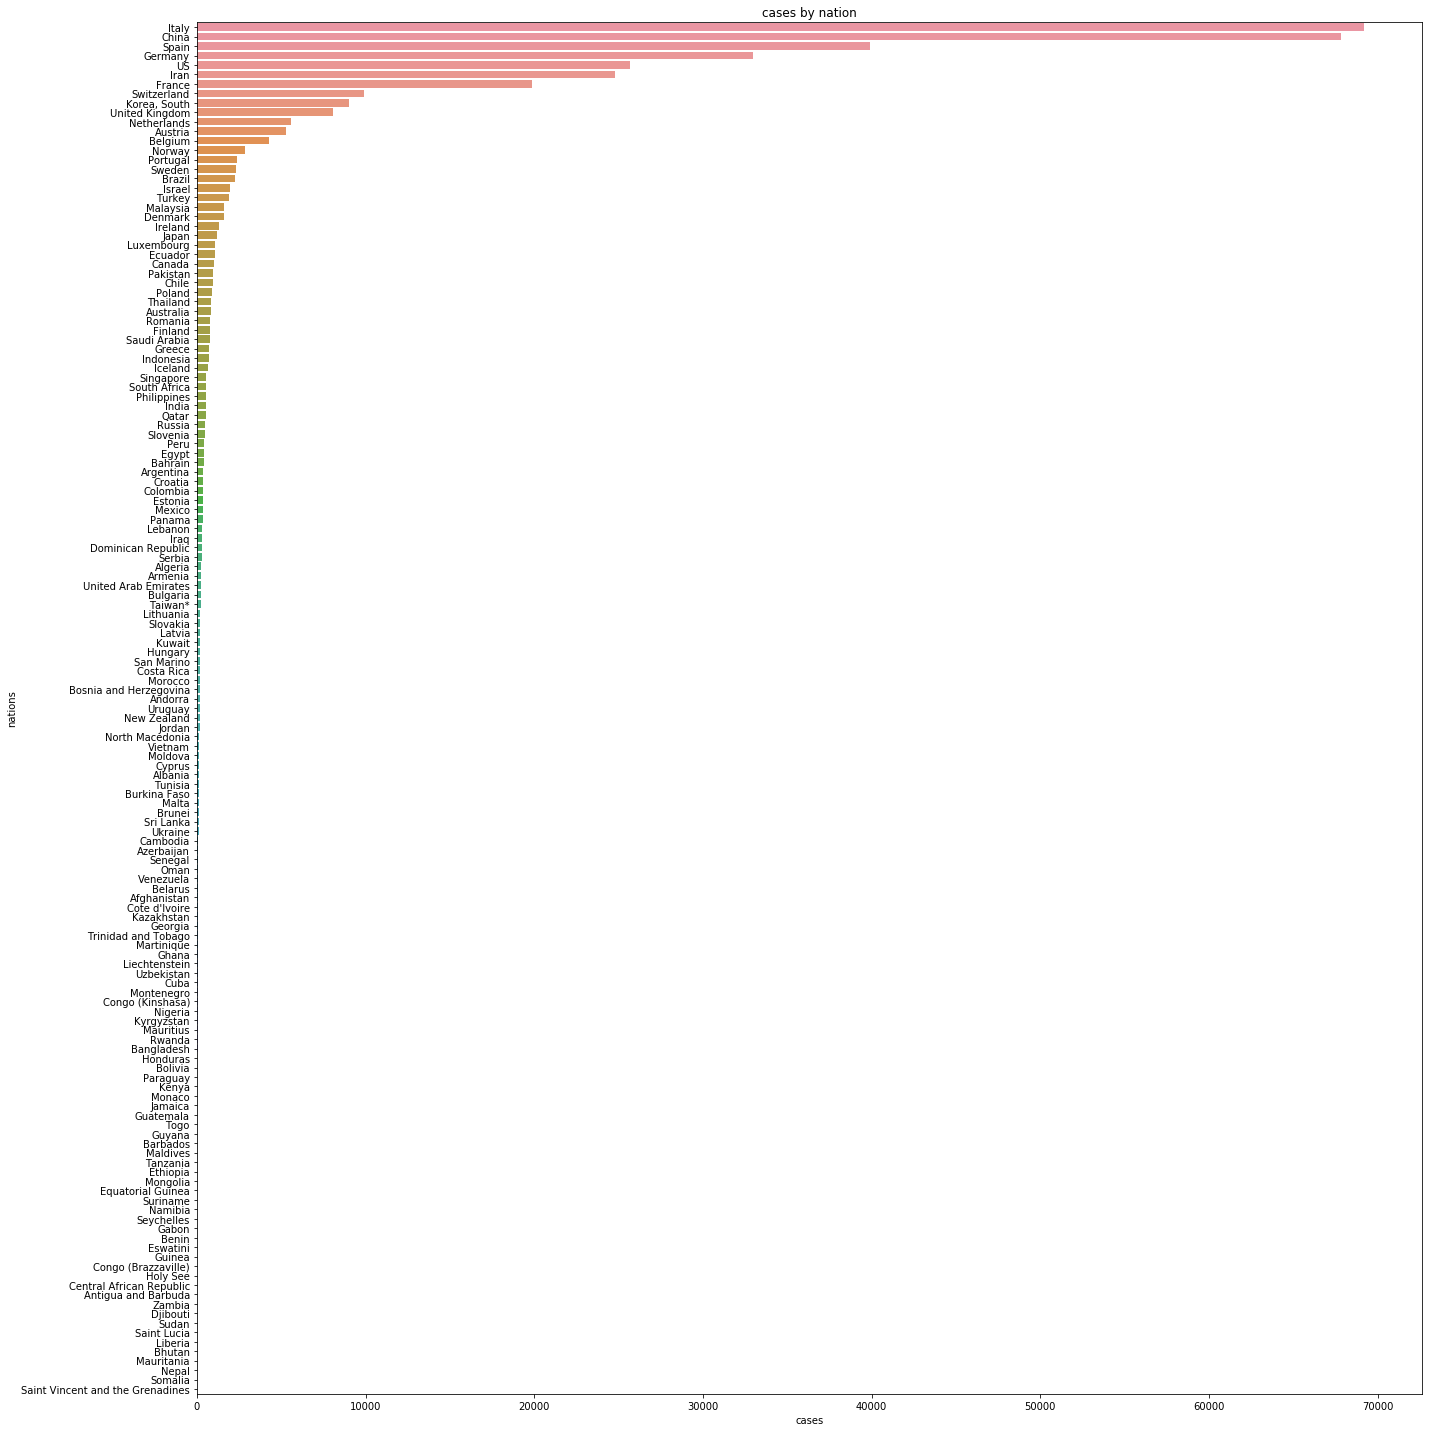

In [2]:
x = len([nation for nation in train['Country/Region'].unique()])
print("There are {} different nations in the training dataset.".format(x))

s = train.groupby('Country/Region').ConfirmedCases.max()
nations_cases = [x for x in s.index if s[x]]
print("{} of these nations have confirmed cases of COVID-19.".format(len(nations_cases)))

s_2 = train.groupby('Country/Region').Fatalities.max()
nations_deaths = [x for x in s_2.index if s_2[x]]
print("In {} of these nations, people have died of COVID-19.".format(len(nations_deaths)))

barplot_df = pd.DataFrame({
    'nations': nations_cases,
    'cases': [s[x] for x in s.index if s[x]]
})
plt.figure(figsize=(20, 20))
sns.barplot(x="cases", y="nations", data=barplot_df.sort_values(by='cases', ascending=False))
plt.title('cases by nation')
plt.tight_layout()
plt.show()

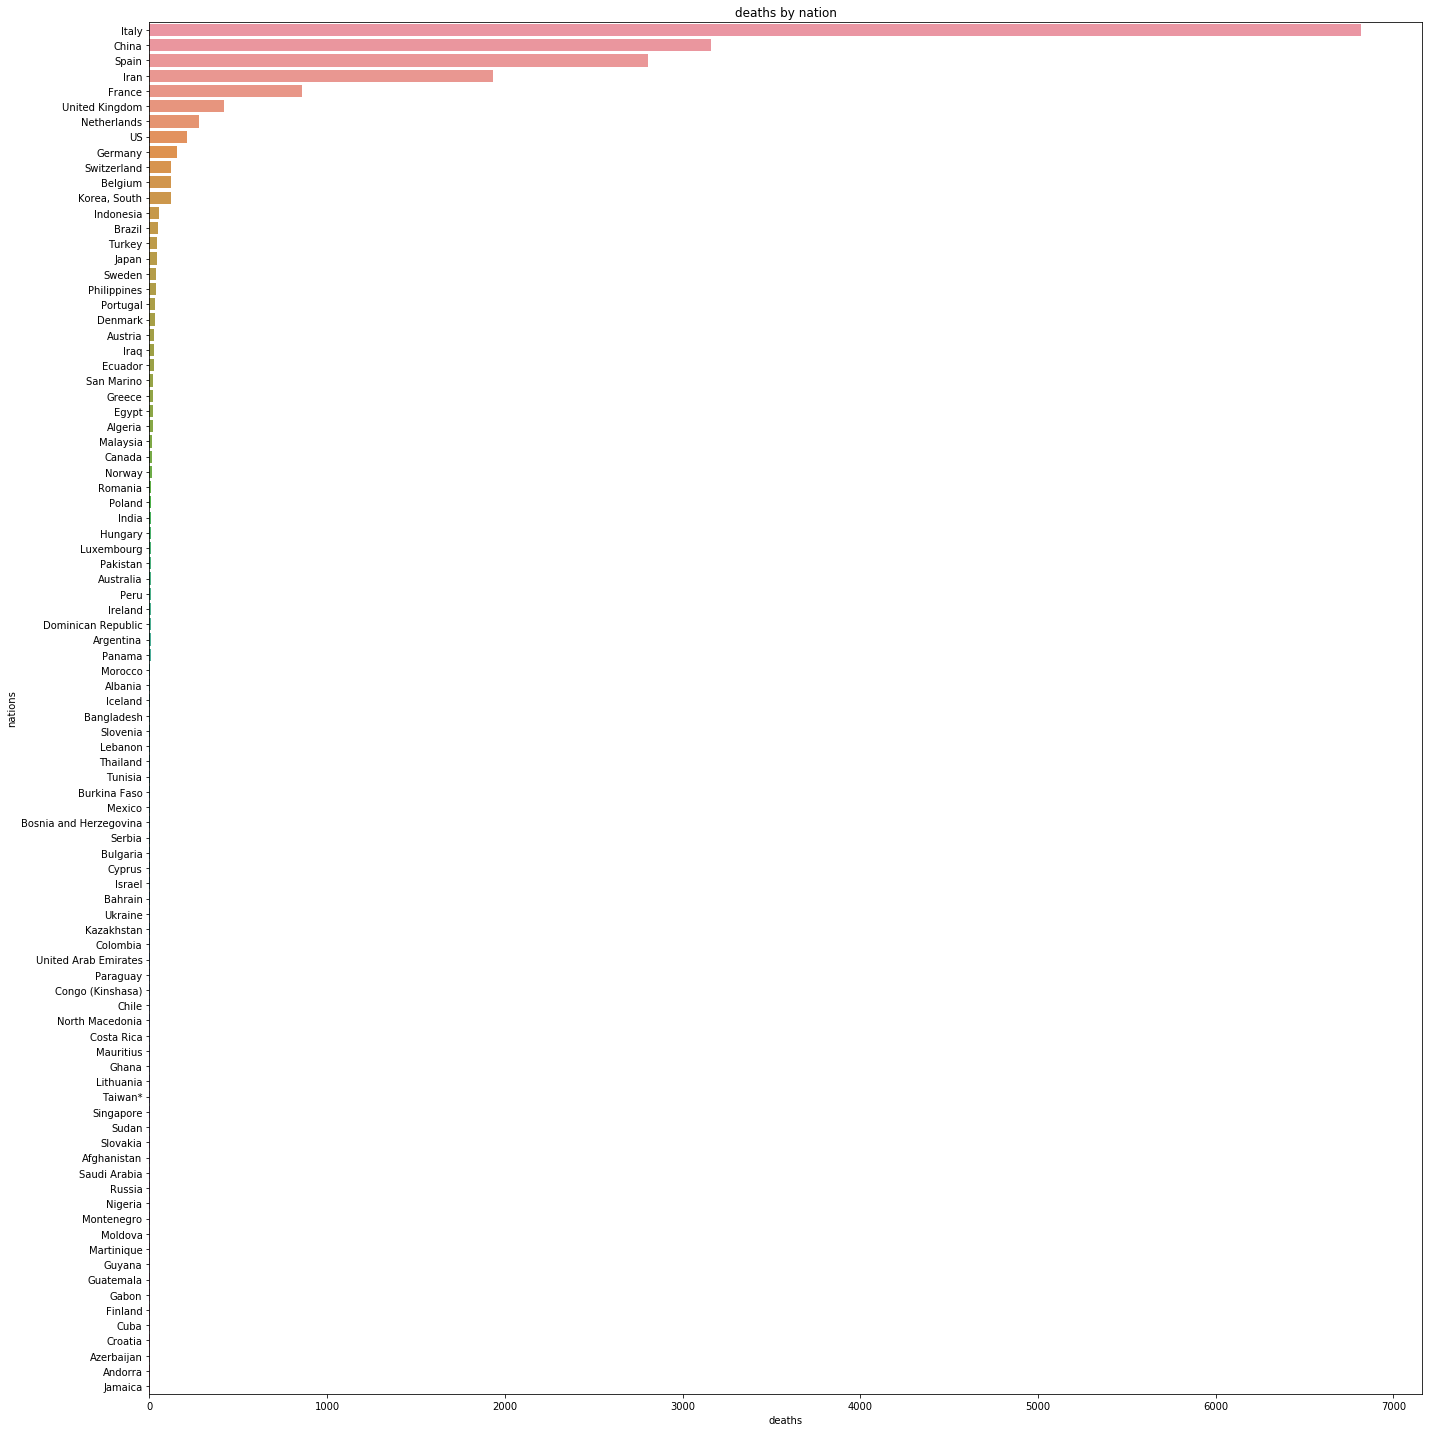

In [3]:
barplot_df = pd.DataFrame({
    'nations': nations_deaths,
    'deaths': [s_2[x] for x in s_2.index if s_2[x]]
})
plt.figure(figsize=(20, 20))
sns.barplot(x="deaths", y="nations", data=barplot_df.sort_values(by='deaths', ascending=False))
plt.title('deaths by nation')
plt.tight_layout()
plt.show()

Here is the weather data:
* `temp`: Mean temperature for the day in degrees Fahrenheit to tenths. Missing = 9999.9
* `max`: Maximum temperature reported during the day in Fahrenheit to tenths--time of max temp report varies by country and region, so this will sometimes not be the max for the calendar day. Missing = 9999.9
* `min`: Minimum temperature reported during the day in Fahrenheit to tenths--time of min temp report varies by country and region, so this will sometimes not be the min for the calendar day. Missing = 9999.9
* `stp`: Mean station pressure for the day in millibars to tenths. Missing = 9999.9
* `wdsp`: Mean wind speed for the day in knots to tenths. Missing = 999.9
* `prcp`: Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with the midnight observation--i.e., may include latter part of previous day. .00 indicates no measurable precipitation (includes a trace). Missing = 99.9
* `fog`: Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day

In [4]:
%%time
client = bigquery.Client()
dataset_ref = client.dataset("noaa_gsod", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

tables = list(client.list_tables(dataset))

table_ref = dataset_ref.table("stations")
table = client.get_table(table_ref)
stations_df = client.list_rows(table).to_dataframe()

table_ref = dataset_ref.table("gsod2020")
table = client.get_table(table_ref)
twenty_twenty_df = client.list_rows(table).to_dataframe()

stations_df['STN'] = stations_df['usaf'] + '-' + stations_df['wban']
twenty_twenty_df['STN'] = twenty_twenty_df['stn'] + '-' + twenty_twenty_df['wban']

cols_1 = ['STN', 'mo', 'da', 'temp', 'min', 'max', 'stp', 'wdsp', 'prcp', 'fog']
cols_2 = ['STN', 'country', 'state', 'call', 'lat', 'lon', 'elev']
weather_df = twenty_twenty_df[cols_1].join(stations_df[cols_2].set_index('STN'), on='STN')

weather_df.tail(10)

Using Kaggle's public dataset BigQuery integration.
CPU times: user 2min 21s, sys: 5.35 s, total: 2min 27s
Wall time: 5min 28s


,STN,mo,da,temp,min,max,stp,wdsp,prcp,fog,country,state,call,lat,lon,elev
940877,477430-99999,03,15,43.4,33.8,53.6,999.9,13.9,99.99,1,JA,None,RJOH,35.492,133.236,+0006.1
940878,477040-99999,01,12,44.1,42.8,48.2,999.9,7.7,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
940879,477040-99999,01,19,45.0,37.4,51.8,999.9,7,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
940880,477040-99999,02,08,37.3,32.0,44.6,999.9,13.8,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
940881,477040-99999,02,17,38.9,32.0,44.6,999.9,17,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
940882,477040-99999,03,15,41.6,33.8,53.6,999.9,10.9,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
940883,710790-99999,01,05,5.1,2.3,6.8,980.8,5.5,0.18,1,CA,None,CYTH,55.801,-97.864,+0222.2
940884,711210-99999,02,20,22.0,12.2,37.4,935.2,7.5,0.02,1,CA,None,CYED,53.667,-113.467,+0688.0
940885,722593-03985,01,10,68.1,66.2,69.8,984.7,12.6,99.99,1,US,TX,KFWS,32.565,-97.308,+0213.4
940886,722700-23044,02,11,48.4,36.0,60.1,877.6,6.9,0.19,1,US,TX,KELP,31.811,-106.376,+1194.2


In [5]:
from scipy.spatial.distance import cdist

weather_df['day_from_jan_first'] = (weather_df['da'].apply(int)
                                   + 31*(weather_df['mo']=='02') 
                                   + 60*(weather_df['mo']=='03')
                                   + 91*(weather_df['mo']=='04')  
                                   )

mo = train['Date'].apply(lambda x: x[5:7])
da = train['Date'].apply(lambda x: x[8:10])
train['day_from_jan_first'] = (da.apply(int)
                               + 31*(mo=='02') 
                               + 60*(mo=='03')
                               + 91*(mo=='04')  
                              )

C = []
for j in train.index:
    df = train.iloc[j:(j+1)]
    mat = cdist(df[['Lat','Long', 'day_from_jan_first']],
                weather_df[['lat','lon', 'day_from_jan_first']], 
                metric='euclidean')
    new_df = pd.DataFrame(mat, index=df.Id, columns=weather_df.index)
    arr = new_df.values
    new_close = np.where(arr == np.nanmin(arr, axis=1)[:,None],new_df.columns,False)
    L = [i[i.astype(bool)].tolist()[0] for i in new_close]
    C.append(L[0])
    
train['closest_station'] = C
train = train.set_index('closest_station').join(weather_df[['temp', 'min', 'max', 'stp', 'wdsp', 'prcp', 'fog']], ).reset_index().drop(['index'], axis=1)
train.sort_values(by=['Id'], inplace=True)
#train = train.set_index('Id')
train.index = train['Id'].apply(lambda x: x-1)
train.head()

KeyError: 'Id'

In [6]:
train.to_csv('training_data_with_weather_info_week_1.csv')

# Week 2:

In [7]:
data_path = Path('/kaggle/input/covid19-global-forecasting-week-2/')
train_2 = pd.read_csv(data_path / 'train.csv')
test_2 = pd.read_csv(data_path / 'test.csv')
display(train_2.head())
#display(test_2.head())

train['country+province'] = train['Country/Region'].fillna('') + '-' + train['Province/State'].fillna('')
train_2['country+province'] = train_2['Country_Region'].fillna('') + '-' + train_2['Province_State'].fillna('')
df = train.groupby('country+province')[['Lat', 'Long']].mean()
train_2['Lat'] = train_2['country+province'].apply(lambda x: df.loc[x, 'Lat'])
train_2['Long'] = train_2['country+province'].apply(lambda x: df.loc[x, 'Long'])
mo = train_2['Date'].apply(lambda x: x[5:7])
da = train_2['Date'].apply(lambda x: x[8:10])
train_2['day_from_jan_first'] = (da.apply(int)
                               + 31*(mo=='02') 
                               + 60*(mo=='03')
                               + 91*(mo=='04')  
                              )

C = []
for j in train_2.index:
    df = train_2.iloc[j:(j+1)]
    mat = cdist(df[['Lat','Long', 'day_from_jan_first']],
                weather_df[['lat','lon', 'day_from_jan_first']], 
                metric='euclidean')
    new_df = pd.DataFrame(mat, index=df.Id, columns=weather_df.index)
    arr = new_df.values
    new_close = np.where(arr == np.nanmin(arr, axis=1)[:,None],new_df.columns,False)
    L = [i[i.astype(bool)].tolist()[0] for i in new_close]
    C.append(L[0])
    
train_2['closest_station'] = C

train_2= train_2.set_index('closest_station').join(weather_df[['temp', 'min', 'max', 'stp', 'wdsp', 'prcp', 'fog']], ).reset_index().drop(['index'], axis=1)
train_2.sort_values(by=['Id'], inplace=True)
train_2 = train_2.set_index('Id')
train_2.index = train_2['Id'].apply(lambda x: x-1)
display(train_2.head())

train_2.to_csv('training_data_with_weather_info_week_2.csv')

,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities
0,1,Afghanistan,NaN,2020-01-22,0.0,0.0
1,2,Afghanistan,NaN,2020-01-23,0.0,0.0
2,3,Afghanistan,NaN,2020-01-24,0.0,0.0
3,4,Afghanistan,NaN,2020-01-25,0.0,0.0
4,5,Afghanistan,NaN,2020-01-26,0.0,0.0


KeyError: 'Angola-'